In [1]:
import pandas
import numpy as np
import uproot
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
import gc
import sys
import seaborn as sns
from scipy import interpolate

sys.path.insert(0, "../python")
from common import *

C:\Users\konst\AppData\Roaming\Python\Python36\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#file_name = '../../../tuples/results/DY_amcatnloFXFX_part1.root'
#file_name = '../../../tuples/results/TTTo2L2Nu_test_part1.root'
#file_name = '../../../tuples/results/TTToHadronic_PSweights_part1.root'
#file_name = '../../../tuples/results/TTToSemiLeptonic_PSweights_part1.root'
#file = uproot.open(file_name)

#file_name = '../../results/0607_all/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8.hdf5'
#file_name = '../../results/0607_all/TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8.hdf5'
#file_name = '../../results/0607_all/TTToHadronic_TuneCP5_PSweights_13TeV-powheg-pythia8.hdf5'
#file_name = '../../results/0607_all/TTToSemiLeptonic_TuneCP5_PSweights_13TeV-powheg-pythia8.hdf5'

#folder='../../results/0607_all/'
#folder='../../results/0610_s3/'
folder='../../results/0723_s1p2/'
file_name = folder + 'DYJetsToLL_M-50.hdf5'
#file_name = folder + 'TTTo2L2Nu_TuneCP5_PSweights_13TeV-powheg-pythia8.hdf5'
#file_name = folder + 'TTToHadronic_TuneCP5_PSweights_13TeV-powheg-pythia8.hdf5'
#file_name = folder + 'TTToSemiLeptonic_TuneCP5_PSweights_13TeV-powheg-pythia8.hdf5'


#file_name = '../../results/DY_s3.hdf5'
#file_name = '../../results/TT_had_s3.hdf5'
#file_name = '../../results/TT_lep_s2.hdf5'
#file_name = '../../results/TT_semi_s2.hdf5'
#df = pandas.read_hdf(file_name, start=0, stop=int(1e6))
df = pandas.read_hdf(file_name)

In [4]:
#df_qcd = pandas.read_hdf(folder + 'ZeroBias.hdf5')
df_qcd = pandas.read_hdf(folder + 'TTToHadronic_TuneCP5.hdf5')

In [13]:
#df = file['taus'].arrays(outputtype=pandas.DataFrame)
#df.columns = [ c.decode('utf-8') for c in df.columns ]

In [3]:
df_taus = df[df['gen_tau'] == 1].copy(deep=True)

In [4]:
del df
gc.collect()

111

In [5]:
df = df_qcd.append(df_taus)

In [7]:
del df_taus
gc.collect()

97

In [6]:
def ProcessDF(df):
    epsilon=TauLosses.epsilon
    df['tau_vs_jet'] = pandas.Series(df['deepId_tau'] / (df['deepId_tau'] + df['deepId_jet'] + epsilon), index=df.index)
    df['tau_vs_mu'] = pandas.Series(df['deepId_tau'] / (df['deepId_tau'] + df['deepId_mu'] + epsilon), index=df.index)
    df['tau_vs_e'] = pandas.Series(df['deepId_tau'] / (df['deepId_tau'] + df['deepId_e'] + epsilon), index=df.index)
    df['tau_vs_all'] = pandas.Series(df['deepId_tau'], index=df.index)

In [7]:
ProcessDF(df)
#ProcessDF(df_qcd)

In [137]:
np.amax(np.isnan(df['tau_vs_e']))

False

(array([   805.,  10978.,  50235., 154716., 265392., 272918., 170550.,
         59398.,  13770.,   1238.]),
 array([-2.02787305e-07, -1.62734705e-07, -1.22682104e-07, -8.26295036e-08,
        -4.25769031e-08, -2.52430254e-09,  3.75282980e-08,  7.75808985e-08,
         1.17633499e-07,  1.57686100e-07,  1.97738700e-07]),
 <a list of 10 Patch objects>)

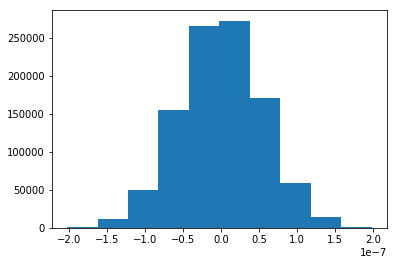

In [10]:
plt.hist(df['deepId_tau'] + df['deepId_e'] + df['deepId_mu'] + df['deepId_jet'] - 1)

In [8]:
#presel = (df['pt'] > 20) & (df['pt'] <= 100) & (np.abs(df['eta']) < 2.3)
presel = (df['pt'] > 20) & (np.abs(df['eta']) < 2.3)

In [9]:
def create_roc_ratio(x1, y1, x2, y2):
    idx_min = np.argmax((x2 >= x1[0]) & (y2 > 0))
    if x2[-1] <= x1[-1]:
        idx_max = x2.shape[0]
    else:
         idx_max = np.argmax(x2 > x1[-1])
    sp = interpolate.interp1d(x1, y1)
    x1_upd = x2[idx_min:idx_max]
    y1_upd = sp(x1_upd)
    return x1_upd, y1_upd / y2[idx_min:idx_max]

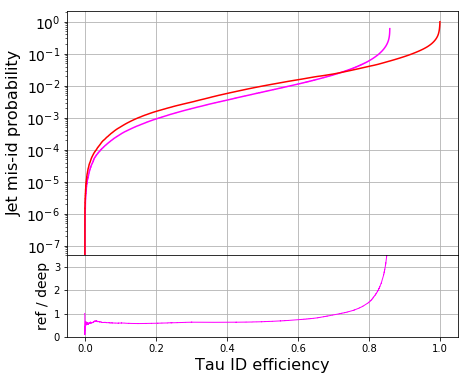

In [10]:
df_tj = df[((df['gen_tau'] == True) | (df['gen_jet'] == True)) & presel]
fpr_ref, tpr_ref, thresholds_ref = metrics.roc_curve(df_tj['gen_tau'], df_tj['refId_jet'], drop_intermediate=False)
fpr, tpr, thresholds = metrics.roc_curve(df_tj['gen_tau'], df_tj['tau_vs_jet'])
tpr_ratio, fpr_ratio = create_roc_ratio(tpr_ref[:-1], fpr_ref[:-1], tpr, fpr)

fig, (ax, ax_ratio) = plt.subplots(2, 1, figsize=(7,6), sharex=True, gridspec_kw = {'height_ratios':[3, 1]})
ax.semilogy(tpr_ref[:-1], fpr_ref[:-1], 'magenta', tpr, fpr, 'red')

ax_ratio.plot(tpr_ratio, fpr_ratio, 'magenta', linewidth=1)
#plt.ylim([0,0.2])
#plt.xlim([.4, 0.8])
ax_ratio.set_ylim([0, 3.5])
ax.set_ylabel('Jet mis-id probability', fontsize=16)
ax_ratio.set_xlabel('Tau ID efficiency', fontsize=16)
ax_ratio.set_ylabel('ref / deep', fontsize=14)
ax.tick_params(labelsize=14)
ax_ratio.tick_params(labelsize=10)

ax.grid(True)
ax_ratio.grid(True)

plt.subplots_adjust(hspace=0)
plt.show()
fig.savefig('tau_vs_jet.pdf', bbox_inches='tight')

In [12]:
def FindThresholds(df, var_name, pt_bins, target_eff):
    thr = np.zeros(len(pt_bins) - 1)
    for n in range(0, len(thr)):
        x = df[(df['gen_tau']== 1) & (df['pt'] > pt_bins[n]) & (df['pt'] <= pt_bins[n+1]) & (np.abs(df['eta']) < 2.3)]
        thr[n] = np.percentile(x[var_name], (1-target_eff) * 100)
    return thr

In [13]:
def FindThreshold(df, var_name, target_eff):
    x = df[(df['gen_tau']== 1) & (df['pt'] > 20) & (np.abs(df['eta']) < 2.3)]
    return np.percentile(x[var_name], (1-target_eff) * 100)

In [14]:
def efficiency(x, thrs):
    N = x.shape[0]
    eff = np.zeros(thrs.shape[0])
    eff_down = np.zeros(thrs.shape[0])
    eff_up = np.zeros(thrs.shape[0])
    if N != 0:
        for k in range(thrs.shape[0]):
            n = np.count_nonzero(x > thrs[k])
            eff[k] = n/N
            eff_down[k], eff_up[k] = proportion_confint(n, N, 1-0.682689, 'beta')
    return eff, eff_down, eff_up

In [15]:
def rate_curve(df, variables, thresholds):
    rates = np.zeros(thresholds.shape)
    events = df.groupby(['run', 'lumi', 'evt'])
    print("before n: ", df.shape[0])
    n_events = len(events)
    print("N done:", n_events)
    for v in range(0, len(variables)):
        var = variables[v]
        x = events[var].max()
        for k in range(0, thresholds.shape[0]):
            n_passed = np.count_nonzero(x > thresholds[k, v])
            rates[k, v] = float(n_passed) / n_events
    return rates

In [11]:
df_qcd.sort_values(by=['run', 'lumi', 'evt'], inplace=True)

In [12]:
len(df_qcd.groupby(['run', 'lumi', 'evt']))

11985472

In [16]:
def efficiency_curve(x, n_bins):
    eff = np.linspace(0, 1, num=n_bins)
    thr = np.percentile(x, (1-eff) * 100)
    return eff, thr

In [17]:
def rate_eff_curve(df_rate, df_eff, variables, n_bins):
    eff = np.zeros((n_bins, len(variables)))
    thr = np.zeros(eff.shape)
    for v in range(0, len(variables)):
        var = variables[v]
        eff[:, v], thr[:, v] = efficiency_curve(df_eff[var], n_bins)
    rates = rate_curve(df_rate, variables, thr)
    return rates, eff, thr

In [15]:
fpr, tpr, thresholds = rate_eff_curve(df_qcd[(df_qcd['pt'] > 20) & (np.abs(df_qcd['eta']) < 2.3)],
                                      df[(df['gen_tau'] == True) & (df['pt'] > 20) & (np.abs(df['eta']) < 2.3)],
                                      ['refId_jet', 'tau_vs_jet', 'tau_vs_all'], 100)

before n:  38554834
N done: 11865154


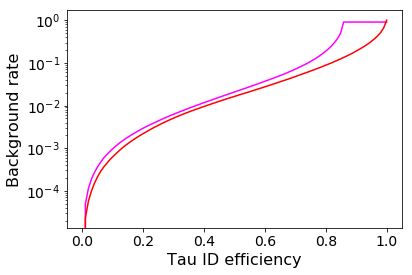

In [16]:
plt.semilogy(tpr[:, 0], fpr[:, 0], 'magenta', tpr[:, 1], fpr[:, 2], 'red')
#plt.ylim([0,0.2])
#plt.xlim([.4, 0.8])
plt.xlabel('Tau ID efficiency', fontsize=16)
plt.ylabel('Background rate', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('TThad_rate.pdf', bbox_inches='tight')

In [18]:
thr_effs = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
#thr_effs = np.array([0.6])
thr_jet = FindThreshold(df, 'tau_vs_jet', thr_effs)
thr_jet

array([0.96617708, 0.95792807, 0.94798403, 0.92678112, 0.88362183,
       0.81796918, 0.71031571, 0.51207218])

In [29]:
thr_effs = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
#thr_effs = np.array([0.6])
thr_e = FindThreshold(df, 'tau_vs_e', thr_effs)
thr_e

array([0.97659943, 0.96659088, 0.95139703, 0.94002532, 0.93445722,
       0.93068014, 0.92353872, 0.73677367])

In [30]:
thr_effs = np.array([0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99, 0.995])
thr_mu = FindThreshold(df, 'tau_vs_mu', thr_effs)
thr_mu

array([0.99927339, 0.99835222, 0.99778491, 0.99751026, 0.99669641,
       0.99344313, 0.74838998, 0.25273132])

In [19]:
def diff_efficiency(df_true, df_fake, var_name, var_bins, thrs, discr_name):
    eff = np.zeros([len(var_bins)-1, 2, thrs.shape[0]])
    eff_up = np.zeros(eff.shape)
    eff_down = np.zeros(eff.shape)
    for n in range(0, len(var_bins) - 1):
        x_true = df_true[(df_true[var_name] > var_bins[n]) & (df_true[var_name] <= var_bins[n+1])
                         & (np.abs(df_true['eta']) < 2.3)][discr_name]
        x_fake = df_fake[(df_fake[var_name] > var_bins[n]) & (df_fake[var_name] <= var_bins[n+1])
                          & (np.abs(df_fake['eta']) < 2.3)][discr_name]
        eff[n, 0, :], eff_down[n, 0, :], eff_up[n, 0, :] = efficiency(x_true, thrs)
        eff[n, 1, :], eff_down[n, 1, :], eff_up[n, 1, :] = efficiency(x_fake, thrs)
    eff_up = eff_up - eff
    eff_down = eff - eff_down
    return eff, eff_up, eff_down

In [35]:
def draw_diff_eff(eff, eff_up, eff_down, var_bins, thrs, x_title, y1_title, y2_title, output_file_name):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    for k in range(thrs.shape[0]):
        ax1.errorbar((var_bins[1:]+var_bins[0:-1])/2, eff[:, 0, k], xerr=((var_bins[1:]-var_bins[0:-1])/2),
                     yerr=[eff_down[:, 0, k], eff_up[:, 0, k]], linestyle='None')
        ax2.errorbar((var_bins[1:]+var_bins[0:-1])/2, eff[:, 1, k], xerr=((var_bins[1:]-var_bins[0:-1])/2),
                     yerr=[eff_down[:, 1, k], eff_up[:, 1, k]], linestyle='None')
    ax1.set_xlim([var_bins[0], var_bins[-1]])
    ax1.set_xlabel(x_title, fontsize=16)
    ax1.set_ylabel(y1_title, fontsize=16)
    ax1.tick_params(labelsize=14)

    ax2.set_xlim([var_bins[0], var_bins[-1]])
    ax2.set_ylim([1e-6, 1])
    ax2.set_yscale('log')
    ax2.set_xlabel(x_title, fontsize=16)
    ax2.set_ylabel(y2_title, fontsize=16)
    ax2.tick_params(labelsize=14)
    

    plt.show()
    fig.savefig(output_file_name, bbox_inches='tight')

In [33]:
pt = np.array([20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 250, 300, 350, 400])
#, 450, 500, 600, 700, 800, 900, 1000])
eff_pt, eff_pt_up, eff_pt_down = diff_efficiency(df[(df['gen_tau']== 1)], df[(df['gen_mu']== 1)], 'pt', pt,
                                                 thr_mu, 'tau_vs_mu')

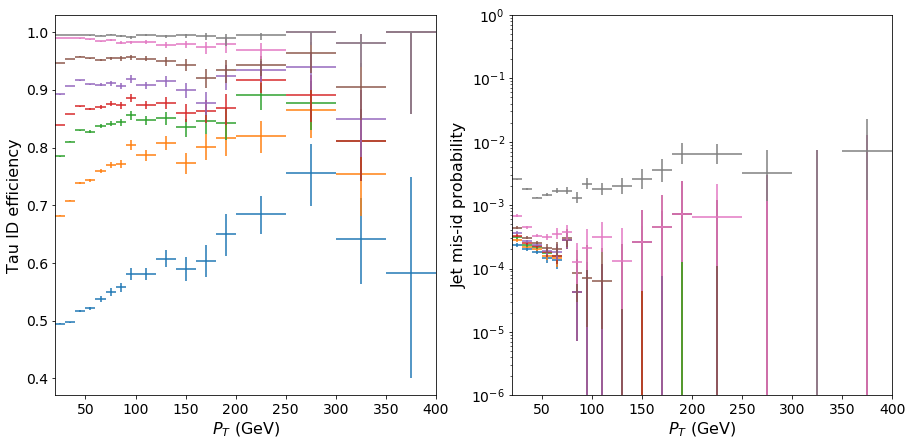

In [36]:
draw_diff_eff(eff_pt, eff_pt_up, eff_pt_down, pt, thr_jet, '$P_{T}$ (GeV)', 'Tau ID efficiency',
              'Jet mis-id probability', 'DY_jet_pt.pdf')

In [26]:
eta = np.arange(-2.3, 2.31, 0.2)
eff_eta, eff_eta_up, eff_eta_down = diff_efficiency(df[(df['gen_tau']== 1)], df[(df['gen_jet']== 1)],
                                                    'eta', eta, thr_jet, 'tau_vs_jet')

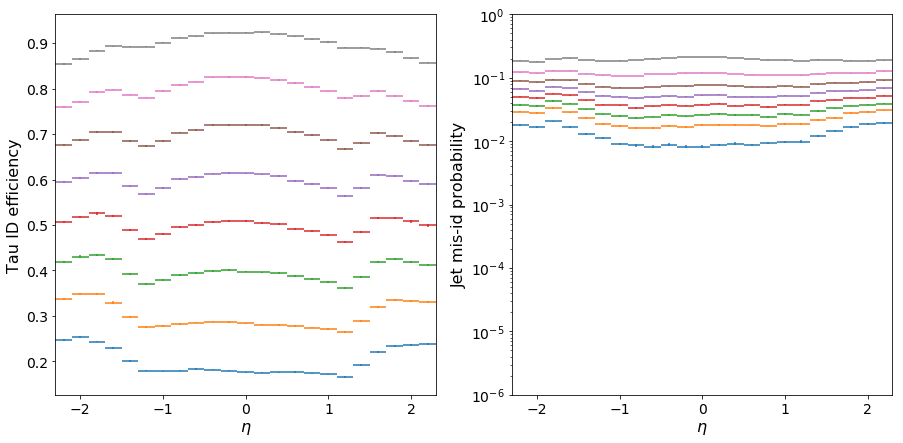

In [28]:
draw_diff_eff(eff_eta, eff_eta_up, eff_eta_down, eta, thr_jet, '$\eta$', 'Tau ID efficiency',
              'Jet mis-id probability', 'DY_jet_eta.pdf')

In [33]:
phi = np.arange(-3.14, 3.141, 6.28/20)
eff_phi, eff_phi_up, eff_phi_down = diff_efficiency(df[(df['gen_tau']== 1)], df[(df['gen_mu']== 1)],
                                                    'phi', phi, thr_mu, 'tau_vs_mu')

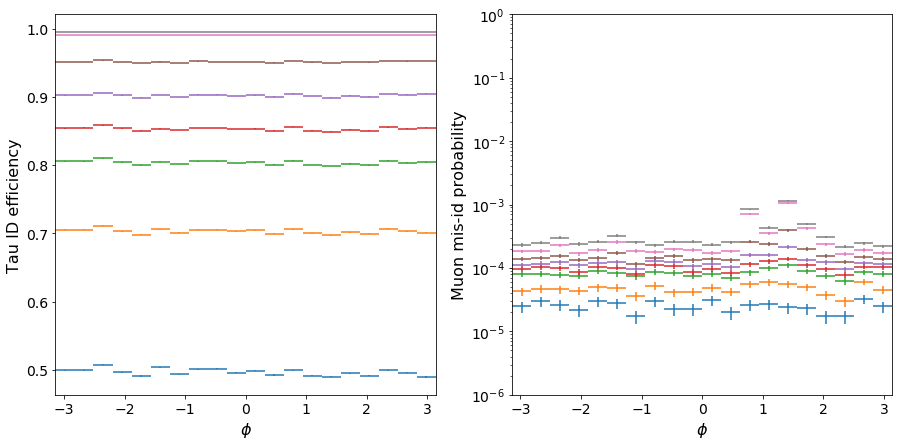

In [34]:
draw_diff_eff(eff_phi, eff_phi_up, eff_phi_down, phi, thr_mu, '$\phi$', 'Tau ID efficiency',
              'Muon mis-id probability', 'DY_muon_phi.pdf')

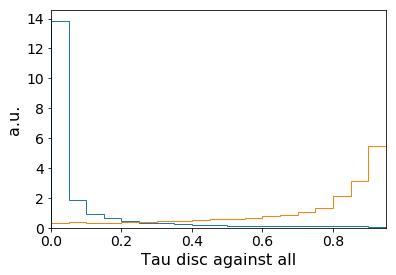

In [120]:
bins = np.arange(0, 1, 0.05)
#bins = np.arange(0, 2, 0.1)
#x = df[(df['gen_tau']== 1) &(df['pt'] > 20) & (df['pt'] <= 30) & (np.abs(df['eta']) < 2.3)]
sel = (df['pt'] > 20) & (np.abs(df['eta']) < 2.3)
#plt.hist(x['tau_vs_jet'], bins=bins)
plt.hist(df[(df['gen_tau'] != 1) & sel]['tau_vs_all'], bins=bins, histtype='step', stacked=True, fill=False, density=True)
plt.hist(df[(df['gen_tau'] == 1) & sel]['tau_vs_all'], bins=bins, histtype='step', stacked=True, fill=False, density=True)
#plt.hist(df['pt'], bins=bins, weights=df['weight'])
#plt.hist(df[(df['gen_tau']== 1) & (df['pt'] < 30) & (df['pt'] > 20)]['weight'], bins=bins)
#plt.hist(df[(df['gen_tau']== 1)]['weight'], bins=bins)
plt.xlim([bins[0], bins[-1]])
plt.xlabel('Tau disc against all', fontsize=16)
plt.ylabel('a.u.', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('DY_tau_vs_all_hist.pdf', bbox_inches='tight')

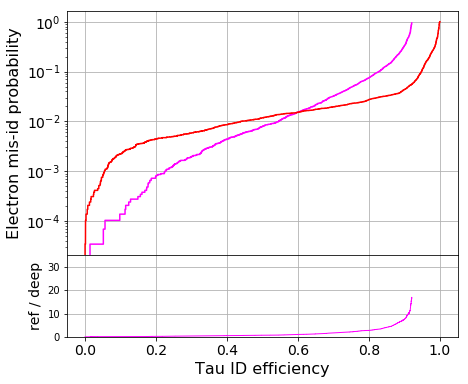

In [9]:
df_et = df[((df['gen_tau'] == True) | (df['gen_e'] == True)) & presel & (df['pt'] > 100) & (df['pt'] < 200)]
fpr_ref, tpr_ref, thresholds_ref = metrics.roc_curve(df_et['gen_tau'], df_et['refId_e'])
fpr, tpr, thresholds = metrics.roc_curve(df_et['gen_tau'], df_et['tau_vs_e'])
tpr_ratio, fpr_ratio = create_roc_ratio(tpr_ref[:-1], fpr_ref[:-1], tpr, fpr)

fig, (ax, ax_ratio) = plt.subplots(2, 1, figsize=(7,6), sharex=True, gridspec_kw = {'height_ratios':[3, 1]})
ax.semilogy(tpr_ref[:-1], fpr_ref[:-1], 'magenta', tpr, fpr, 'red')

ax_ratio.plot(tpr_ratio, fpr_ratio, 'magenta', linewidth=1)
#plt.ylim([0,0.2])
#plt.xlim([.4, 0.8])
ax_ratio.set_ylim([0, 35])
ax.set_ylabel('Electron mis-id probability', fontsize=16)
ax_ratio.set_xlabel('Tau ID efficiency', fontsize=16)
ax_ratio.set_ylabel('ref / deep', fontsize=14)
ax.tick_params(labelsize=14)
ax_ratio.tick_params(axis='x', labelsize=14)
ax_ratio.tick_params(axis='y', labelsize=10)
ax.grid(True)
ax_ratio.grid(True)

plt.subplots_adjust(hspace=0)
plt.show()
fig.savefig('tau_vs_ele.pdf', bbox_inches='tight')

In [9]:
df_mt = df[((df['gen_tau'] == True) | (df['gen_mu'] == True)) & presel]
fpr_ref, tpr_ref, thresholds_ref = metrics.roc_curve(df_mt['gen_tau'], df_mt['refId_mu_loose'])
fpr_ref_2, tpr_ref_2, thresholds_ref_2 = metrics.roc_curve(df_mt['gen_tau'], df_mt['refId_mu_tight'])
fpr, tpr, thresholds = metrics.roc_curve(df_mt['gen_tau'], df_mt['tau_vs_mu'])

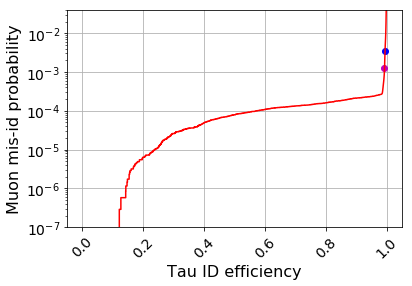

In [10]:
plt.semilogy(tpr_ref[1:2], fpr_ref[1:2], 'bo', tpr_ref_2[1:2], fpr_ref_2[1:2], 'mo', tpr, fpr, 'red')
plt.ylim([1e-7, 0.04])
#plt.xlim([.98, 1])
plt.xlabel('Tau ID efficiency', fontsize=16)
plt.ylabel('Muon mis-id probability', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.grid(True)
plt.savefig('tau_vs_mu.pdf', bbox_inches='tight')

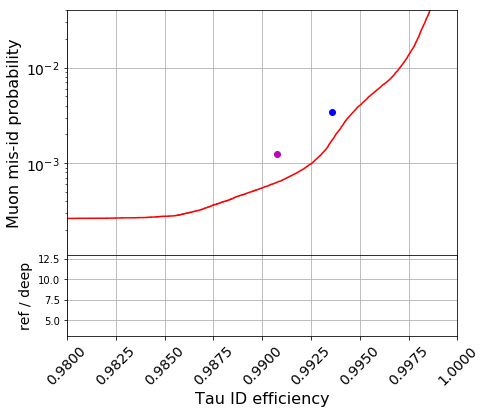

In [11]:
sp = interpolate.interp1d(tpr, fpr)

tpr_ratio = [tpr_ref[1:2], tpr_ref_2[1:2]]
fpr_ratio = [fpr_ref[1:2], fpr_ref_2[1:2]] / sp(tpr_ratio)

fig, (ax, ax_ratio) = plt.subplots(2, 1, figsize=(7,6), sharex=True, gridspec_kw = {'height_ratios':[3, 1]})

ax.semilogy(tpr_ref[1:2], fpr_ref[1:2], 'bo', tpr_ref_2[1:2], fpr_ref_2[1:2], 'mo', tpr, fpr, 'red')
ax_ratio.plot(tpr_ratio[0], fpr_ratio[0], 'bo', tpr_ratio[1], fpr_ratio[1], 'mo')

ax.set_ylim([1.1e-4, 0.04])
ax.set_xlim([.98, 1])
ax_ratio.set_ylim([3, 13])

ax.set_ylabel('Muon mis-id probability', fontsize=16)
ax_ratio.set_xlabel('Tau ID efficiency', fontsize=16)
ax_ratio.set_ylabel('ref / deep', fontsize=14)
ax.tick_params(labelsize=14)
ax_ratio.tick_params(axis='x', labelsize=14, rotation=45)
ax_ratio.tick_params(axis='y', labelsize=10)
ax.grid(True)
ax_ratio.grid(True)

plt.subplots_adjust(hspace=0)
plt.show()
fig.savefig('tau_vs_mu_zoom.pdf', bbox_inches='tight')